$$
\huge\text{Modeling Online Toxicity with LSTMs}\\
\large\text{An interactive lab}\\
\text{Andrew Riberio @ https://github.com/Andrewnetwork}
$$
[ Skill Level : Beginner ] [ Interactive ]

Welcome to this interactive laboratory for exploring the application of LSTM's to modeling toxicity in online dialog. Given the interactive componennts, you will be able to effortlessly play with various model parameters, hyperparameters, and visualize results in an effort to understand the model. I also include a section at the end which deals with outputting your results to a submission format and how to submit those results.  

Outline

1. Libraries and Environment Setup
2. Preprocessing 
3. Modeling 
4. Visualizing and Interpreting Results

Resources and Sources 
* https://www.kaggle.com/sbongo/for-beginners-tackling-toxic-using-keras
* http://www.deeplearningbook.org/contents/rnn.html

**NOTE**: In order for the interactive componnents of this kernel to function, you must either fork this kernel or download it to your local machine which has the required environment and dependencies. The simplest method is to fork the kernel here on kaggle. 

**$\large\text{1. Libraries and Environment Setup}$**

In [2]:
import sys, os, re, csv, codecs
import numpy as np 
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import load_model

from ipywidgets import interact,interact_manual
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Andre\Anaconda3\envs\SinkEnv2018\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


$\large\text{2. Preprocessing }$

Load our training and test data using pandas into dataframe variables amicably named. 

*Note:* If you are using this kernel as a fork on kaggle, you will not need to change the training and test paths. If you have a local version of this kernel, you must download the training data and change the paths below to your local copy of the data. 

In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

Basic data information.

In [4]:
print("Shape of the training data: {0}.".format(train.shape) )
print("Shape of the test data: {0}.".format(test.shape))

# View some of the training data. 
train.head()

Shape of the training data: (159571, 8).
Shape of the test data: (153164, 2).


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Interactive data visualization

In [5]:
# Cashed filter computations for the visualization below. 
cashedFilters = {}

In [6]:
# An interactive widget for exploring the data. 
def visRow(row):
    print( row["comment_text"] )
    print ("{0} - Toxic( {1} ) - Severe Toxic ( {2} ) - Obscene( {3} ) - Threat ( {4} ) - Insult ( {5} ) - Identity Hate ( {6} )"
           .format(row["id"],row["toxic"],row["severe_toxic"],
                   row["obscene"],row["threat"],row["insult"],row["identity_hate"]))
    
def categoryVis(toxic,severeToxic, obscene, threat, insult, identHate,idx=0):
    try:
        visRow(cashedFilters[toxic,severeToxic, obscene, threat, insult, identHate].iloc[idx])
        
    except KeyError:
        print("Computing filter...")
        filterRes = train[train.apply(lambda x: x["toxic"] == toxic and x["severe_toxic"] == severeToxic and x["obscene"] == obscene 
                                  and x["threat"] == threat and x["insult"] == insult and x["identity_hate"] == identHate , axis=1)]
        cashedFilters[toxic,severeToxic, obscene, threat, insult, identHate] =  filterRes
        print("Done.\n---------")
        
        visRow(filterRes.iloc[idx])
    
interact(categoryVis,toxic=False,severeToxic=False, obscene=False, threat=False, insult=False, identHate=False,idx=(0,100))

interactive(children=(Checkbox(value=False, description='toxic'), Checkbox(value=False, description='severeToxic'), Checkbox(value=False, description='obscene'), Checkbox(value=False, description='threat'), Checkbox(value=False, description='insult'), Checkbox(value=False, description='identHate'), IntSlider(value=0, description='idx'), Output()), _dom_classes=('widget-interact',))

<function __main__.categoryVis>

Split training data into data and label vectors. 

In [4]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

y_train = train[list_classes].values
list_sentences_train = train["comment_text"]

list_sentences_test = test["comment_text"]

Tokenize the words. 

In [5]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

The following shows the result of the tokenizing process. Our text comments are now sequences of token ids.

In [9]:
print(list_tokenized_train[:1])

[[688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]]


Padd our sequences so we can have a fixed training input size. 

In [6]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

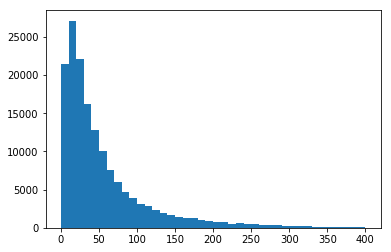

In [11]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

$\large\text{3. Modeling }$

In [7]:
embed_size = 128

inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 2
model.fit(X_t,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

In [8]:
#model.save('lstm_toxic.h5')
model = load_model("./models/lstm_toxic.h5")

$\large\text{4. Visualizing and Interpreting Results }$

In [9]:
def testModel(text):
    textSeq = tokenizer.texts_to_sequences([text])
    t = pad_sequences(textSeq, maxlen=maxlen)
    prediction = model.predict(t)[0]
    print("Toxic( {0:f} ) - Severe Toxic ( {1:f} ) - Obscene( {2:f} ) - Threat ( {3:f} ) - Insult ( {4:f} ) - Identity Hate ( {5:f} )"
          .format(prediction[0],prediction[1],prediction[2],prediction[3],prediction[3],prediction[4],prediction[5]))
interact(testModel,text="Testing 1 2 3")

interactive(children=(Text(value='Testing 1 2 3', description='text'), Output()), _dom_classes=('widget-interact',))

<function __main__.testModel>

In [11]:
validationData = train.tail(15958)
validationDataText = validationData["comment_text"]
validationTokens = tokenizer.texts_to_sequences(validationDataText)
X_validation = pad_sequences(validationTokens, maxlen=maxlen)
y_validation = validationData[list_classes].values
validationPred = model.predict(X_validation)

In [37]:
validationPred[2]

array([0.53858185, 0.00062895, 0.11353013, 0.00247297, 0.23746552,
       0.01172623], dtype=float32)

In [33]:
validationData.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
143613,001e50c9719a815a,Yes you did. And you admitted to doing it. See...,0,0,0,0,0,0
143614,00237e81e55e290e,"""\n\n Delete \n\nHey there, do you want page ...",0,0,0,0,0,0
143615,0026b847c32d821b,I am so sorry for creating another account I f...,0,0,0,0,0,0
143616,002beab256a522d2,Gift Giving In The Laws of Manu \n\nThere is n...,0,0,0,0,0,0
143617,002eb973f922651e,"Martens Deletion. \n\nHello, \nYou might like ...",0,0,0,0,0,0


In [46]:
validationData.iloc[2]["comment_text"]

'I am so sorry for creating another account I feel like such an idiot right now. I will definitely take six months off to think about what I have done and promise never to create any more accounts ever again and hope to come back (3, Febuary 2011) and sort this out and hope to get my original account back.'

In [ ]:
testPred = model.predict(X_te)

In [ ]:
["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
data_to_submit = pd.DataFrame.from_items([
    ('id',test["id"]),
    ('toxic',testPred[:,0]),
    ('severe_toxic',testPred[:,1]),
    ('obscene',testPred[:,2]),
    ('threat',testPred[:,3]),
    ('insult',testPred[:,4]),
    ('identity_hate',testPred[:,5])
])

In [ ]:
data_to_submit.to_csv('csv_to_submit.csv', index = False)

In [ ]:
data_to_submit.head()